In [7]:
import matplotlib.dates as mdates
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator

from src.visualisation.visualize import apply_mpl_settings

apply_mpl_settings()
import datetime
import json
from collections import defaultdict
from pathlib import Path

import numpy as np
import scipy.stats as stats

#from src.data.make_dataset import get_single_bp
#from src.data.detectors import get_det_pos, get_df_and_metadata
from src.data.analysis import Circle, get_mean_std, get_timestamp
#from src.features.build_features import perc_error_to_ref_df
from src.visualisation.visualize import apply_defaults, apply_grid

# Dataset

In [9]:
ref_dataset = '2020_10_12_Co60'
ref_dose_Gy = 60.
ref_dataset_path = Path('..', '..', 'data', 'interim', 'foils', ref_dataset)
list_of_ref_datasets = sorted((entry.name for entry in ref_dataset_path.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
' '.join(list_of_ref_datasets)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/interim/foils/2020_10_12_Co60'

In [10]:
dataset = '2022_11_17_bp'
dataset_path = Path('..', '..', 'data', 'interim', 'foils', dataset)
list_of_datasets = sorted((entry.name for entry in dataset_path.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
' '.join(list_of_datasets)

'1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40'

In [11]:
[entry.name for entry in Path(dataset_path, list_of_datasets[0]).iterdir()]

['stages.pdf',
 'raw.npy',
 'aligned-det-circle.json',
 'raw-aligned.npy',
 'raw-after-ff.npy',
 'ff-circle.json',
 'angle.npy',
 'raw-bg-image-removed.npy']

In [5]:
df_ref_data = defaultdict(list)
filename = 'raw-after-ff'
for det in list_of_ref_datasets:
    df_ref_data['det_id'].append(int(det))
    data = np.load(f'../../data/interim/ifj_data/{ref_dataset}/{det}/{filename}.npy')
    analysis_circle = Circle.from_json(f'../../data/interim/ifj_data/{ref_dataset}/{det}/ff-circle.json')
    mean, std = get_mean_std(data, analysis_circle)
    df_ref_data[f'signal_mean'].append(mean)
    df_ref_data[f'signal_std'].append(std)
print("done")
df_ref = pd.DataFrame.from_dict(df_ref_data)    
df_ref['dose_Gy_per_signal'] = ref_dose_Gy / df_ref['signal_mean']
df_ref.head()

done


,det_id,signal_mean,signal_std,dose_Gy_per_signal
0,2,210.060776,16.679506,0.285632
1,3,211.975494,19.560139,0.283052
2,4,209.217438,19.174362,0.286783
3,5,214.960999,21.665409,0.279120
4,6,217.313828,23.446766,0.276098


In [6]:
df_data = defaultdict(list)
for det in list_of_datasets:
    df_data['det_id'].append(int(det))
    df_data['timestamp'].append(get_timestamp(f'../../data/raw/ifj_data/{dataset}/{det}/Pos0/metadata.txt'))

    analysis_circle = Circle.from_json(f'../../data/interim/ifj_data/{dataset}/{det}/ff-circle.json')
    aligned_det_circle = Circle.from_json(f'../../data/interim/ifj_data/{dataset}/{det}/aligned-det-circle.json')
    aligned_analysis_circle = Circle(x=aligned_det_circle.x, y=aligned_det_circle.y, r=analysis_circle.r)

    for filename in ('raw', 'raw-bg-image-removed', 'raw-aligned', 'raw-after-ff'):
        data = np.load(Path(dataset_path, det, f'{filename}.npy'))
        circle = analysis_circle
        if 'aligned' in filename:
            circle = aligned_analysis_circle
        mean, std = get_mean_std(data, circle)
        df_data[f'{filename}_signal_mean'].append(mean)
        df_data[f'{filename}_signal_std'].append(std)
df = pd.DataFrame.from_dict(df_data)
df.head()

,det_id,timestamp,raw_signal_mean,raw_signal_std,raw-bg-image-removed_signal_mean,raw-bg-image-removed_signal_std,raw-aligned_signal_mean,raw-aligned_signal_std,raw-after-ff_signal_mean,raw-after-ff_signal_std
0,2,2020-10-09 12:33:52+02:00,1177.993896,14.062359,151.303131,15.361590,151.195953,6.251143,151.242645,13.947777
1,3,2020-10-09 12:37:01+02:00,1166.319336,12.808887,139.605270,13.923957,139.508698,5.088531,139.579041,12.942273
2,4,2020-10-09 12:39:17+02:00,1172.805664,13.158589,146.096664,14.265282,145.980438,5.383973,146.093765,13.499154
3,5,2020-10-09 12:41:18+02:00,1202.302612,14.123713,175.605270,15.231947,175.612549,7.657848,175.671707,14.902644
4,6,2020-10-09 12:43:21+02:00,1195.202881,13.691467,168.472672,14.997613,168.409683,6.670208,168.504303,14.373695


# Figure 1 - raw signal

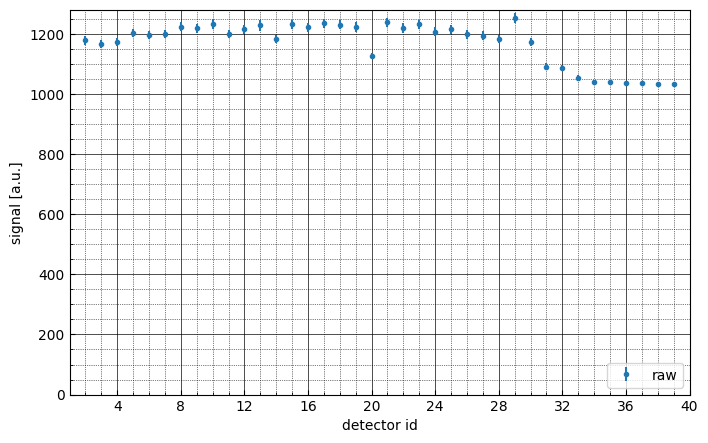

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
ax.errorbar(df.det_id, df['raw_signal_mean'], yerr=df['raw_signal_std'], fmt='', linestyle='', marker='.', label='raw')
apply_defaults(ax)
ax.legend(loc='lower right')
ax.set_xlim(int(min(list_of_datasets, key=lambda s:int(s)))-1, int(max(list_of_datasets, key=lambda s:int(s)))+1);
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('detector id')
ax.set_ylabel('signal [a.u.]');

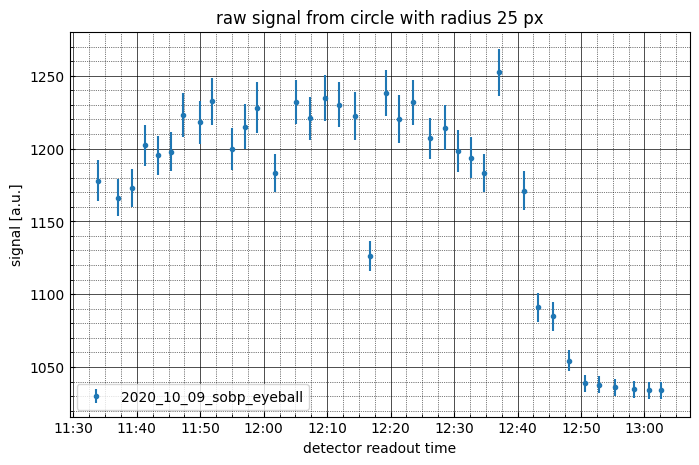

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
ax.errorbar(df.timestamp, df['raw_signal_mean'], yerr=df['raw_signal_std'], fmt='', linestyle='', marker='.', label=dataset, color="C0")
apply_grid(ax)
ax.legend(loc='lower left')
ax.set_xlabel('detector readout time')
ax.set_ylabel('signal [a.u.]');
ax.set_title(f'raw signal from circle with radius {analysis_circle.r} px')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=datetime.timezone(datetime.timedelta(hours=1))))
#ax.set_ylim(0,1700);

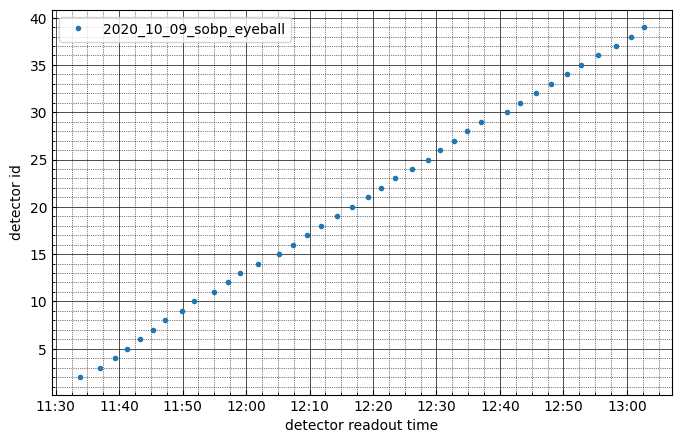

In [9]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(df.timestamp, df.det_id, linestyle='', marker='.', label=dataset, color="C0")
apply_grid(ax)
ax.legend(loc='upper left')
ax.set_xlabel('detector readout time')
ax.set_ylabel('detector id');
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=datetime.timezone(datetime.timedelta(hours=1))))

# Figure 2 - processing

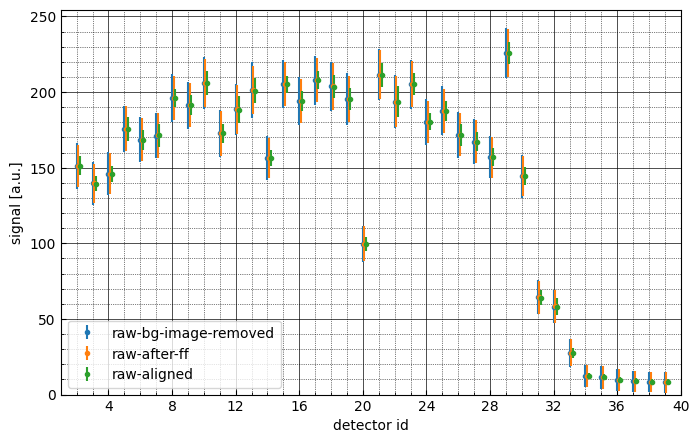

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
for id, filename in enumerate(('raw-bg-image-removed', 'raw-after-ff', 'raw-aligned')):
    ax.errorbar(df.det_id+id/10, df[f'{filename}_signal_mean'], yerr=df[f'{filename}_signal_std'], fmt='', linestyle='', marker='.', label=filename)
apply_defaults(ax)
ax.legend()
ax.set_xlim(int(min(list_of_datasets, key=lambda s:int(s)))-1, int(max(list_of_datasets, key=lambda s:int(s)))+1);
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('detector id')
ax.set_ylabel('signal [a.u.]');

# Figure 3 - doses

In [11]:
df['dose_Gy_uncorrected_mean'] = df['raw-after-ff_signal_mean']
df['dose_Gy_uncorrected_std'] = df['raw-after-ff_signal_std']
for det in list_of_datasets:
    det_id = int(det)
    df.loc[df.det_id==det_id, 'dose_Gy_uncorrected_mean'] *= df_ref.loc[df_ref.det_id==det_id, 'dose_Gy_per_signal'].values[0]
    df.loc[df.det_id==det_id, 'dose_Gy_uncorrected_std'] *= df_ref.loc[df_ref.det_id==det_id, 'dose_Gy_per_signal'].values[0]

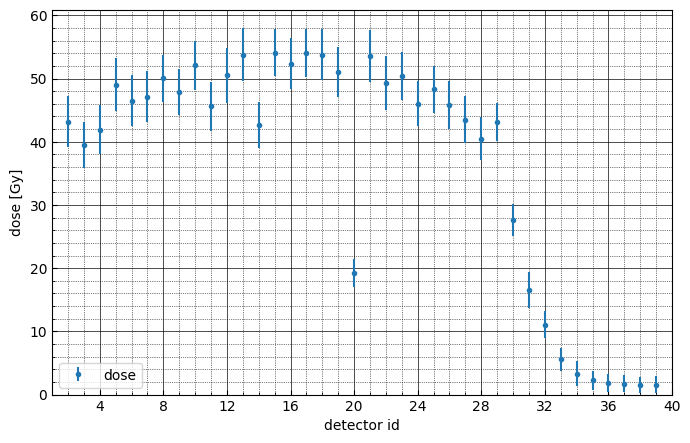

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
ax.errorbar(df.det_id, df['dose_Gy_uncorrected_mean'], yerr=df['dose_Gy_uncorrected_std'], fmt='', linestyle='', marker='.', label='dose')
apply_defaults(ax)
ax.legend(loc=3)
ax.set_xlim(int(min(list_of_datasets, key=lambda s:int(s)))-1, int(max(list_of_datasets, key=lambda s:int(s)))+1);
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('detector id')
ax.set_ylabel('dose [Gy]');

# Figure 4 - 2D images

In [13]:
det = 2

In [14]:
vmax_data = max(np.nanpercentile(a=np.load(Path(dataset_path, f'{det}', f'{filename}.npy')), q=95) for filename in ('raw-bg-image-removed', 'raw-after-ff', 'raw-aligned'))
print(f'vmax_data = {vmax_data}')

vmax_ref_data = max(np.nanpercentile(a=np.load(f'../../data/interim/ifj_data/{ref_dataset}/{det}/{filename}.npy'), q=95) for filename in ('raw-bg-image-removed', 'raw-after-ff', 'raw-aligned'))
print(f'vmax_ref_data = {vmax_ref_data}')

detector_circle = Circle.from_json(f'../../data/interim/ifj_data/{dataset}/{det}lv/det-circle.json')
ff_circle = Circle.from_json(f'../../data/interim/ifj_data/{dataset}/{det}/ff-circle.json')
aligned_det_circle = Circle.from_json(f'../../data/interim/ifj_data/{dataset}/{det}/aligned-det-circle.json')

aligned_analysis_circle = Circle(x=aligned_det_circle.x, y=aligned_det_circle.y, r=ff_circle.r)
aligned_analysis_circle

vmax_data = 151.7067108154297
vmax_ref_data = 228.0


Circle(x=512.0, y=512.0, r=25)

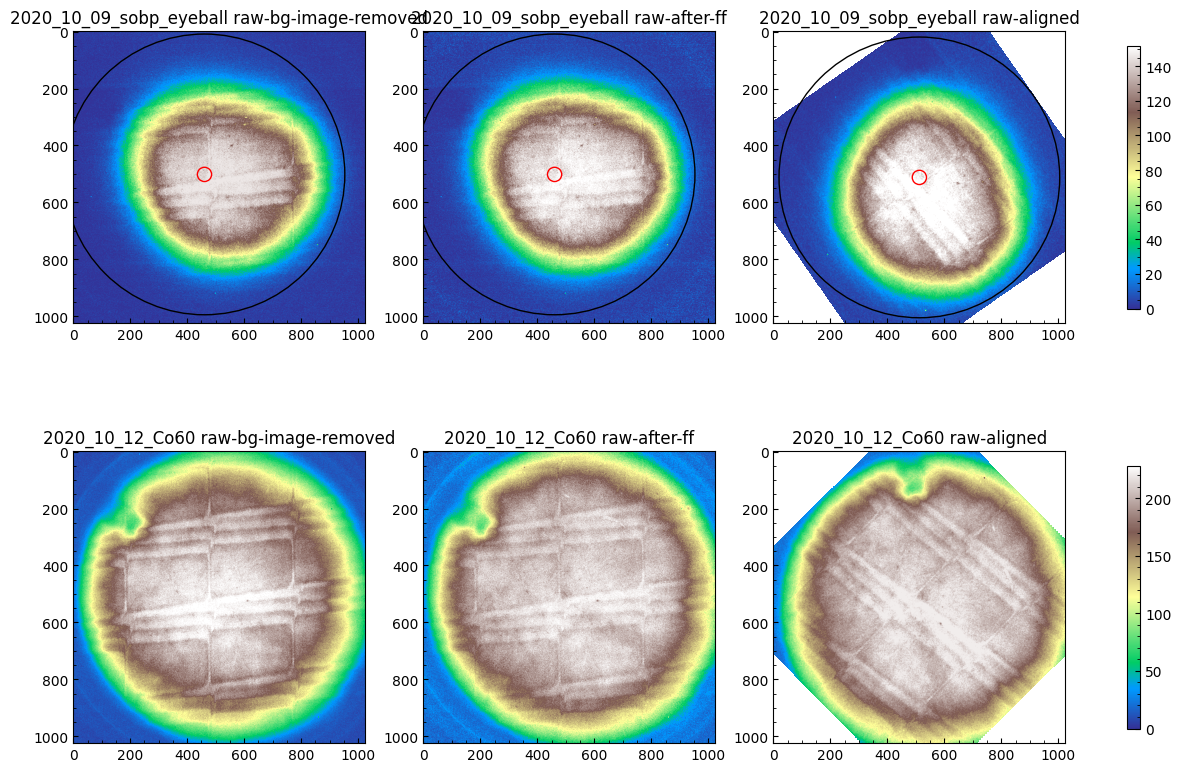

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,10))

for col_id, filename in enumerate(('raw-bg-image-removed', 'raw-after-ff', 'raw-aligned')):
    data = np.load(Path(dataset_path, f'{det}', f'{filename}.npy'))
    data_for_plotting = np.clip(data, a_min=None, a_max=np.nanpercentile(a=data, q=95))
    data_plot = axes[0][col_id].imshow(data_for_plotting, cmap='terrain', vmin=0, vmax=vmax_data);
    axes[0][col_id].set_title(f'{dataset} {filename}')

    ref_data = np.load(f'../../data/interim/ifj_data/{ref_dataset}/{det}/{filename}.npy')
    ref_data_for_plotting = np.clip(ref_data, a_min=None, a_max=np.nanpercentile(a=ref_data, q=95))
    ref_data_plot = axes[1][col_id].imshow(ref_data_for_plotting, cmap='terrain', vmin=0, vmax=vmax_ref_data);
    axes[1][col_id].set_title(f'{ref_dataset} {filename}')

    ax = axes[0][col_id] 
    if 'aligned' in filename:
        ax.add_artist(plt.Circle(xy=(aligned_det_circle.x, aligned_det_circle.y), radius=aligned_det_circle.r, color='black', fill=False, transform=ax.transData))
        ax.add_artist(plt.Circle(xy=(aligned_analysis_circle.x, aligned_analysis_circle.y), radius=aligned_analysis_circle.r, color='red', fill=False, transform=ax.transData))
    else:
        ax.add_artist(plt.Circle(xy=(detector_circle.x, detector_circle.y), radius=detector_circle.r, color='black', fill=False, transform=ax.transData))
        ax.add_artist(plt.Circle(xy=(ff_circle.x, ff_circle.y), radius=ff_circle.r, color='red', fill=False, transform=ax.transData))

fig.colorbar(data_plot, ax=axes[0], location='right', shrink=0.75)
fig.colorbar(ref_data_plot, ax=axes[1], location='right', shrink=0.75);

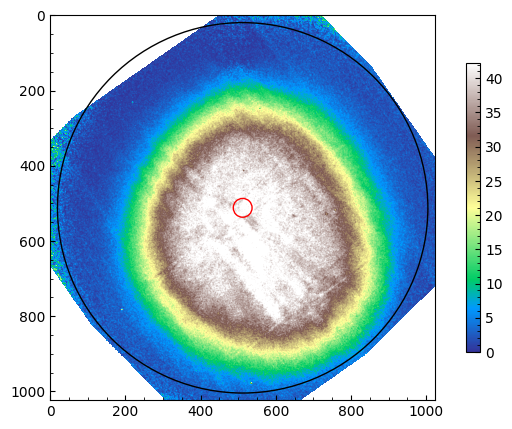

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
data = np.load(Path(dataset_path, f'{det}', f'raw-aligned.npy'))
ref_data = np.load(f'../../data/interim/ifj_data/{ref_dataset}/{det}/raw-aligned.npy')
data_Gy_uncorrected = data * ref_dose_Gy / ref_data
data_for_plotting = np.clip(data_Gy_uncorrected, a_min=None, a_max=np.nanpercentile(a=data_Gy_uncorrected, q=95))
data_plot = ax.imshow(data_for_plotting, cmap='terrain', vmin=0);
ax.add_artist(plt.Circle(xy=(aligned_det_circle.x, aligned_det_circle.y), radius=aligned_det_circle.r, color='black', fill=False, transform=ax.transData))
ax.add_artist(plt.Circle(xy=(aligned_analysis_circle.x, aligned_analysis_circle.y), radius=aligned_analysis_circle.r, color='red', fill=False, transform=ax.transData))
fig.colorbar(data_plot, ax=ax, location='right', shrink=0.75);